# **Problem Statement**

## **Business Context**

Workplace safety in hazardous environments like construction sites and industrial plants is crucial to prevent accidents and injuries. One of the most important safety measures is ensuring workers wear safety helmets, which protect against head injuries from falling objects and machinery. Non-compliance with helmet regulations increases the risk of serious injuries or fatalities, making effective monitoring essential, especially in large-scale operations where manual oversight is prone to errors and inefficiency.

To overcome these challenges, SafeGuard Corp plans to develop an automated image analysis system capable of detecting whether workers are wearing safety helmets. This system will improve safety enforcement, ensuring compliance and reducing the risk of head injuries. By automating helmet monitoring, SafeGuard aims to enhance efficiency, scalability, and accuracy, ultimately fostering a safer work environment while minimizing human error in safety oversight.

## **Objective**

As a data scientist at SafeGuard Corp, you are tasked with developing an image classification model that classifies images into one of two categories:
- **With Helmet:** Workers wearing safety helmets.
- **Without Helmet:** Workers not wearing safety helmets.

## **Data Description**

The dataset consists of **631 images**, equally divided into two categories:

- **With Helmet:** 311 images showing workers wearing helmets.
- **Without Helmet:** 320 images showing workers not wearing helmets.

**Dataset Characteristics:**
- **Variations in Conditions:** Images include diverse environments such as construction sites, factories, and industrial settings, with variations in lighting, angles, and worker postures to simulate real-world conditions.
- **Worker Activities:** Workers are depicted in different actions such as standing, using tools, or moving, ensuring robust model learning for various scenarios.

# **Installing and Importing the Necessary Libraries**

In [25]:
!pip install tensorflow[and-cuda] numpy==1.25.2 -q

  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [26]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available: 1
2.19.0


**Note:**

- After running the above cell, kindly restart the notebook kernel (for Jupyter Notebook) or runtime (for Google Colab) and run all cells sequentially from the next cell.

- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in this notebook.

In [27]:
import os
import random
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2
from google.colab import drive

# Tensorflow modules
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16                                               # Importing confusion_matrix to plot the confusion matrix
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping


# Display images using OpenCV
from google.colab.patches import cv2_imshow

#Imports functions for evaluating the performance of machine learning models
from sklearn.metrics import confusion_matrix, f1_score,accuracy_score, recall_score, precision_score, classification_report
from sklearn.metrics import mean_squared_error as mse                                                 # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [28]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
tf.keras.utils.set_random_seed(812)

# **Data Overview**


##Loading the data

In [29]:
drive.mount('/content/drive')


base_dir = '/content/drive/MyDrive/Colab Notebooks'
images_path = os.path.join(base_dir, 'images_proj.npy')
labels_path = os.path.join(base_dir, 'Labels_proj.csv')

X = np.load(images_path)
y = pd.read_csv(labels_path)

print("Data loaded successfully!")
print(f"Images shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data loaded successfully!
Images shape: (631, 200, 200, 3)
Labels shape: (631, 1)


# **Exploratory Data Analysis**

###Plot random images from each of the classes and print their corresponding labels.

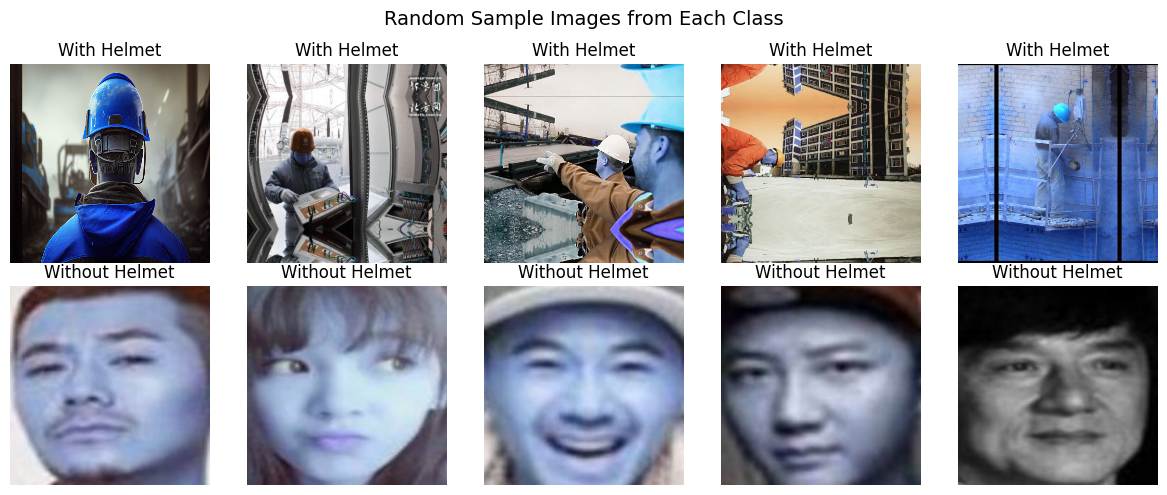

In [30]:
with_helmet = np.where(y == 1)[0]
without_helmet = np.where(y == 0)[0]

fig, ax = plt.subplots(2, 5, figsize=(12,5))

for i in range(5):
    img1 = X[random.choice(with_helmet)]
    img2 = X[random.choice(without_helmet)]

    ax[0, i].imshow(img1.astype('uint8'))
    ax[0, i].set_title("With Helmet")
    ax[0, i].axis('off')

    ax[1, i].imshow(img2.astype('uint8'))
    ax[1, i].set_title("Without Helmet")
    ax[1, i].axis('off')
plt.suptitle("Random Sample Images from Each Class", fontsize=14)
plt.tight_layout()
plt.show()


## Checking for class imbalance


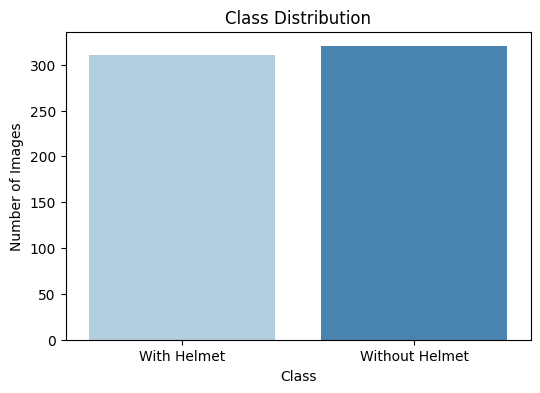

In [31]:
helmet_count = int(np.sum(y == 1))
no_helmet_count = int(np.sum(y == 0))

df_counts = pd.DataFrame({
    "Class": ["With Helmet", "Without Helmet"],
    "Count": [helmet_count, no_helmet_count]
})

plt.figure(figsize=(6,4))
sns.barplot(data=df_counts, x="Class", y="Count", palette="Blues")
plt.title("Class Distribution")
plt.ylabel("Number of Images")
plt.show()

# **Data Preprocessing**

## Converting images to grayscale

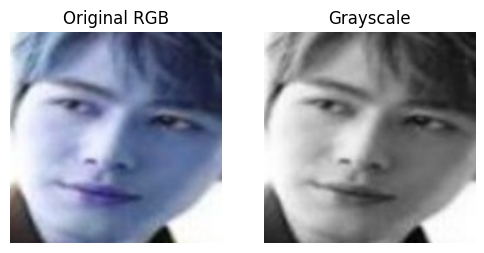

In [32]:
IMG_SIZE = X.shape[1]

if isinstance(y, pd.DataFrame):
    y = y.select_dtypes(include=[np.number]).iloc[:, 0].values
elif isinstance(y, pd.Series):
    y = y.values
y = np.array(y, dtype=int).reshape(-1)

X_gray = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in X])

X_gray = np.array([cv2.resize(img, (IMG_SIZE, IMG_SIZE)) for img in X_gray])

fig, ax = plt.subplots(1, 2, figsize=(6, 3))
rand_idx = np.random.randint(0, len(X))
ax[0].imshow(X[rand_idx].astype('uint8'))
ax[0].set_title('Original RGB'); ax[0].axis('off')
ax[1].imshow(X_gray[rand_idx], cmap='gray')
ax[1].set_title('Grayscale'); ax[1].axis('off')
plt.show()

### Splitting the dataset



In [33]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X_gray, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

### Data Normalization

In [34]:
X_train = X_train.astype('float32') / 255.0
X_val   = X_val.astype('float32') / 255.0
X_test  = X_test.astype('float32') / 255.0

X_train = X_train[..., np.newaxis]
X_val   = X_val[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

# **Model Building**

##Model Evaluation Criterion

## Utility Functions

In [35]:
# defining a function to compute different metrics to check performance of a classification model built using statsmodels
def model_performance_classification(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors).reshape(-1)>0.5

    target = target.to_numpy().reshape(-1)


    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred, average='weighted')  # to compute Recall
    precision = precision_score(target, pred, average='weighted')  # to compute Precision
    f1 = f1_score(target, pred, average='weighted')  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame({"Accuracy": acc, "Recall": recall, "Precision": precision, "F1 Score": f1,},index=[0],)

    return df_perf

In [36]:
def plot_confusion_matrix(model,predictors,target,ml=False):
    """
    Function to plot the confusion matrix

    model: classifier
    predictors: independent variables
    target: dependent variable
    ml: To specify if the model used is an sklearn ML model or not (True means ML model)
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors).reshape(-1)>0.5

    target = target.to_numpy().reshape(-1)

    # Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
    confusion_matrix = tf.math.confusion_matrix(target,pred)
    f, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        confusion_matrix,
        annot=True,
        linewidths=.4,
        fmt="d",
        square=True,
        ax=ax
    )
    plt.show()

##Model 1: Simple Convolutional Neural Network (CNN)

In [37]:
cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,1)),
    MaxPooling2D(2,2),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
cnn.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
cnn.summary()

history_cnn = cnn.fit(X_train, y_train, validation_data=(X_val, y_val),
                      epochs=15, batch_size=32, verbose=1)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 198, 198, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 147456)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │    18,874,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,893,441 (72.07 MB)

 Trainable params: 18,893,441 (72.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 669ms/step - accuracy: 0.5831 - loss: 0.7785 - val_accuracy: 0.9579 - val_loss: 0.4072
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.8722 - loss: 0.3892 - val_accuracy: 0.9158 - val_loss: 0.2654
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9407 - loss: 0.2325 - val_accuracy: 0.9789 - val_loss: 0.1415
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9560 - loss: 0.1530 - val_accuracy: 0.9789 - val_loss: 0.1382
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9573 - loss: 0.1262 - val_accuracy: 0.9789 - val_loss: 0.0912
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9816 - loss: 0.0880 - val_accuracy: 0.9895 - val_loss: 0.0817
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9902 - loss: 0.0643 - val_accuracy: 0.9789 - val_loss: 0.0748
Epoch 8/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9891 - loss: 0.0606 - val_accuracy: 0.9789 -

### Vizualizing the predictions

CNN Test Accuracy: 0.9789473414421082


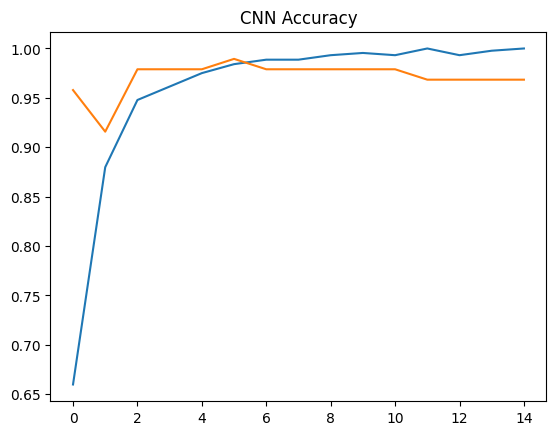


Train performance metrics
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
   Accuracy    Recall  Precision  F1 Score
0  0.997732  0.997732   0.997743  0.997732

Test performance metrics
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
   Accuracy    Recall  Precision  F1 Score
0  0.978947  0.978947   0.979789  0.978933
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


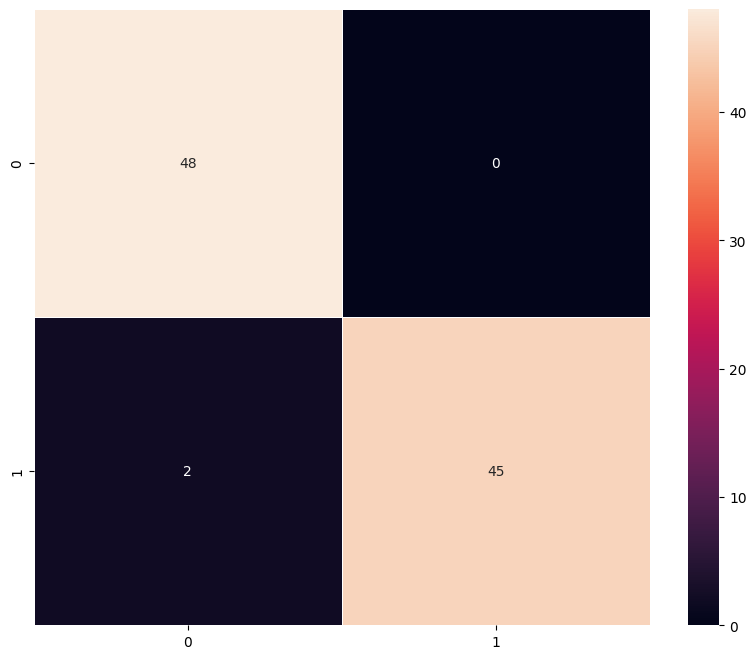

In [38]:
# Plot model Accuracy
cnn_eval = cnn.evaluate(X_test, y_test, verbose=0)
print("CNN Test Accuracy:", cnn_eval[1])

plt.plot(history_cnn.history['accuracy'], label='train')
plt.plot(history_cnn.history['val_accuracy'], label='val')
plt.title('CNN Accuracy');
plt.show()

# Display Train model performance metrics
y_train_pd = pd.Series(y_train)
y_val_pd   = pd.Series(y_val)
y_test_pd  = pd.Series(y_test)

print("\nTrain performance metrics")
model_1_train_perf = model_performance_classification(cnn, X_train, y_train_pd)
print(model_1_train_perf)

# Display Test model performance metrics
print("\nTest performance metrics")
model_1_test_perf = model_performance_classification(cnn, X_test, y_test_pd)
print(model_1_test_perf)

# Confusion matrix
plot_confusion_matrix(cnn, X_test, y_test_pd, ml=True)


# Conclusion:
# The CNN model reached 100% training accuracy after a few epochs, while the validation accuracy stayed around 97%.
# This means the model learned the training images very well but might be overfitting — it may not perform as well on new, unseen images.
# The model also has about 19 million parameters, which makes it quite large for this task and likely to memorize the training data instead of learning general patterns.

## Model 2: (VGG-16 (Base))

In [39]:
# --- Preprocess data for VGG16 ---
X_train_vgg = np.repeat(X_train, 3, axis=-1)
X_val_vgg   = np.repeat(X_val,   3, axis=-1)
X_test_vgg  = np.repeat(X_test,  3, axis=-1)

# VGG16 expects 0–255 float32 inputs with ImageNet mean subtraction
X_train_vgg_pp = preprocess_input((X_train_vgg * 255.0).astype('float32'))
X_val_vgg_pp   = preprocess_input((X_val_vgg   * 255.0).astype('float32'))
X_test_vgg_pp  = preprocess_input((X_test_vgg  * 255.0).astype('float32'))

# --- Early stopping ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    restore_best_weights=True
)

# --- Build VGG16 base model ---
base = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in base.layers:
    layer.trainable = False  # Freeze pretrained layers

# --- Build full model with custom classifier ---
vgg = Sequential([
    base,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.7),
    Dense(1, activation='sigmoid')
])

# --- Compile model ---
vgg.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# --- Train model on preprocessed data ---
history_vgg = vgg.fit(
    X_train_vgg_pp,
    y_train,
    validation_data=(X_val_vgg_pp, y_val),
    epochs=10,
    callbacks=[early_stopping],
    batch_size=32,
    verbose=1
)


Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 485ms/step - accuracy: 0.6498 - loss: 1.5791 - val_accuracy: 0.9579 - val_loss: 0.1583
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - accuracy: 0.8017 - loss: 0.6833 - val_accuracy: 0.9789 - val_loss: 0.0654
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - accuracy: 0.9122 - loss: 0.2267 - val_accuracy: 0.9895 - val_loss: 0.0369
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - accuracy: 0.9398 - loss: 0.1426 - val_accuracy: 0.9789 - val_loss: 0.0259
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.9098 - loss: 0.2102 - val_accuracy: 0.9895 - val_loss: 0.0225
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - accuracy: 0.9639 - loss: 0.1211 - val_accuracy: 0.9895 - val_loss: 0.0181
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.9678 - loss: 0.0719 - val_accuracy: 0.9895 - val_loss: 0.0171
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - accuracy: 0.9732 - loss: 0.0770 - val_accuracy: 0.

### Visualizing the prediction:

VGG-16 (Base) Test Accuracy: 1.0


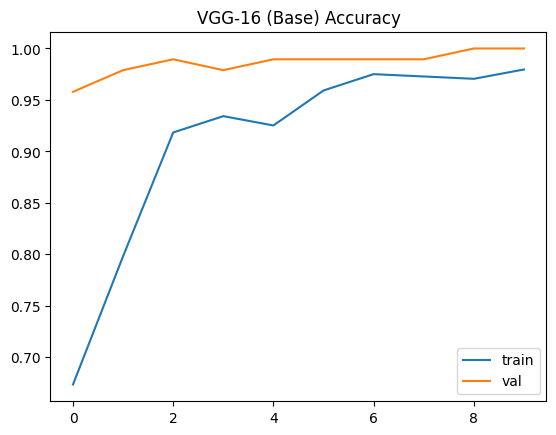


Train performance metrics
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0

Test performance metrics
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


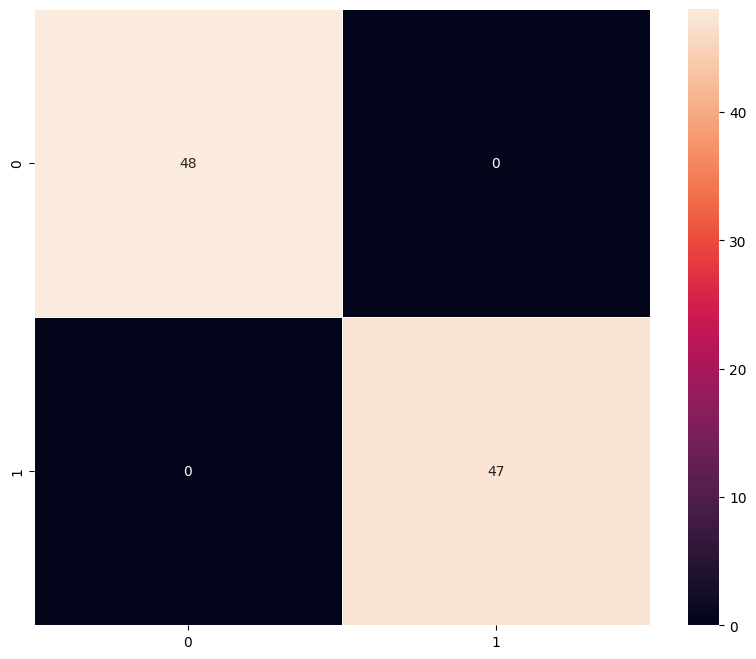

In [40]:
# Plot model Accuracy
y_pred_probs = vgg.predict(X_test_vgg_pp, verbose=0)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

label_map = {0: 'Without Helmet', 1: 'With Helmet'}

vgg_eval = vgg.evaluate(X_test_vgg_pp, y_test, verbose=0)
print("VGG-16 (Base) Test Accuracy:", vgg_eval[1])

plt.plot(history_vgg.history['accuracy'], label='train')
plt.plot(history_vgg.history['val_accuracy'], label='val')
plt.title('VGG-16 (Base) Accuracy')
plt.legend()
plt.show()

# Display Train model performance metrics (use preprocessed arrays)
y_train_pd = pd.Series(y_train.ravel() if getattr(y_train, "ndim", 1) > 1 else y_train)
y_val_pd   = pd.Series(y_val.ravel()   if getattr(y_val, "ndim", 1) > 1 else y_val)
y_test_pd  = pd.Series(y_test.ravel()  if getattr(y_test, "ndim", 1) > 1 else y_test)

print("\nTrain performance metrics")
vgg_train_perf = model_performance_classification(vgg, X_train_vgg_pp, y_train_pd)
print(vgg_train_perf)

# Display Test model performance metrics
print("\nTest performance metrics")
vgg_test_perf = model_performance_classification(vgg, X_test_vgg_pp, y_test_pd)
print(vgg_test_perf)

# Confusion matrix (use preprocessed test data)
plot_confusion_matrix(vgg, X_test_vgg_pp, y_test_pd, ml=True)


# Conclusion:
# Getting a perfect test accuracy of 1.0000 in an image classification task is very unlikely to show the model’s real performance on new data.
# This probably happened because the VGG16 model is very powerful, and your dataset might be too simple or not varied enough.
# VGG16 can easily pick up clear visual differences between the two classes, so it performs perfectly on this particular split — but
# that doesn’t mean it will do as well on more diverse or real-world images.

## Model 3: (VGG-16 (Base + FFNN))

In [41]:
X_train_vgg_pp = preprocess_input((X_train_vgg * 255.0).astype('float32'))
X_val_vgg_pp   = preprocess_input((X_val_vgg   * 255.0).astype('float32'))
X_test_vgg_pp  = preprocess_input((X_test_vgg  * 255.0).astype('float32'))

base3 = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in base3.layers:
    layer.trainable = False   # freeze
# (compile happens after freezing—good)

x = Flatten()(base3.output)          # FFNN head (use Flatten to match your earlier code)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

vgg_ff = Model(inputs=base3.input, outputs=output)
vgg_ff.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

history_vggff = vgg_ff.fit(
    X_train_vgg_pp, y_train,
    validation_data=(X_val_vgg_pp, y_val),
    epochs=15, batch_size=32, verbose=1
)

Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 462ms/step - accuracy: 0.7389 - loss: 3.8226 - val_accuracy: 0.9789 - val_loss: 0.0946
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - accuracy: 0.9952 - loss: 0.0210 - val_accuracy: 0.9895 - val_loss: 0.0074
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 1.0000 - loss: 6.4757e-05 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 5.2538e-04
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - accuracy: 1.0000 - loss: 2.4586e-05 - val_accuracy: 1.0000 - val_loss: 3.2224e-04
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 1.0000 - loss: 3.4504e-06 - val_accuracy: 1.0000 - val_loss: 2.8382e-04
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - accuracy: 1.0000 - loss: 5.2359e-04 - val_accuracy: 1.0000 - val_loss: 3.1426e-04
Epoch 8/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 1.0000 -

#### Visualizing the predictions

VGG-16 (Base + FFNN) Test Accuracy: 1.0


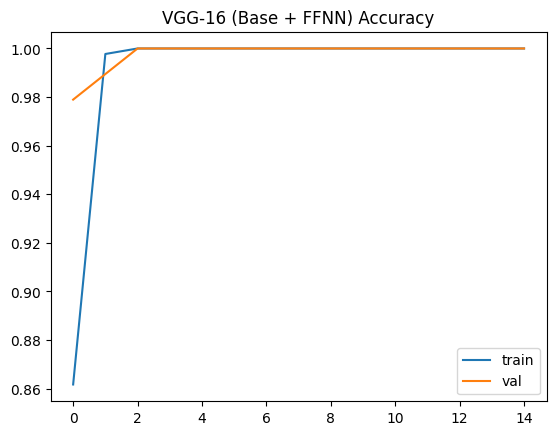


Train performance metrics
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0

Test performance metrics
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


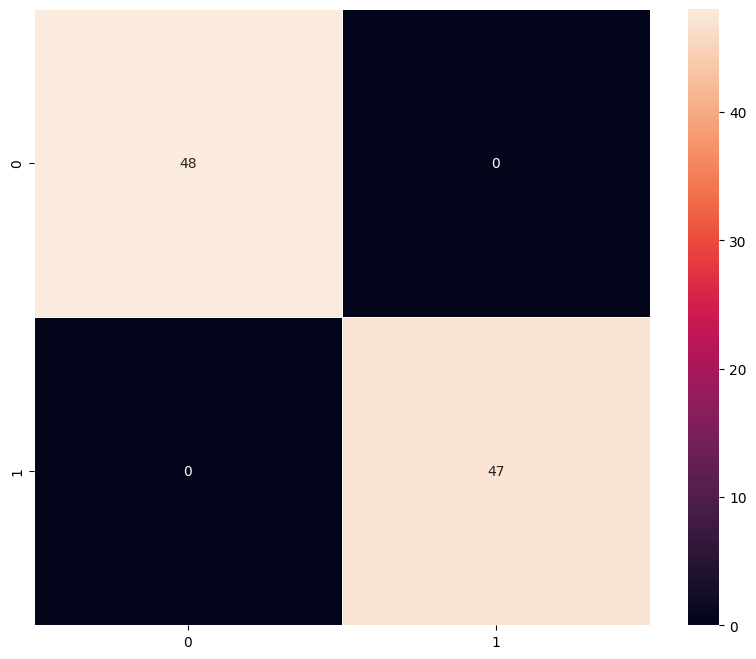

In [42]:
# Predict + threshold
y_pred_probs = vgg_ff.predict(X_test_vgg_pp, verbose=0)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

# Accuracy from Keras
vggff_eval = vgg_ff.evaluate(X_test_vgg_pp, y_test, verbose=0)
print("VGG-16 (Base + FFNN) Test Accuracy:", vggff_eval[1])

# Learning curves
plt.plot(history_vggff.history['accuracy'], label='train')
plt.plot(history_vggff.history['val_accuracy'], label='val')
plt.title('VGG-16 (Base + FFNN) Accuracy')
plt.legend()
plt.show()

# Performance helpers (use preprocessed arrays)
y_train_pd = pd.Series(y_train)
y_val_pd   = pd.Series(y_val)
y_test_pd  = pd.Series(y_test)

print("\nTrain performance metrics")
vggff_train_perf = model_performance_classification(vgg_ff, X_train_vgg_pp, y_train_pd)
print(vggff_train_perf)

print("\nTest performance metrics")
vggff_test_perf = model_performance_classification(vgg_ff, X_test_vgg_pp, y_test_pd)
print(vggff_test_perf)

# Confusion matrix (preprocessed test set)
plot_confusion_matrix(vgg_ff, X_test_vgg_pp, y_test_pd, ml=True)

# Conclusion:
# The model achieved 100% accuracy on both training and test data, likely due to overfitting.
# This suggests that the dataset is relatively simple or limited, allowing the powerful VGG-16 network to memorize the images rather than learn general features.

## Model 4: (VGG-16 (Base + FFNN + Data Augmentation)

- In most of the real-world case studies, it is challenging to acquire a large number of images and then train CNNs.
- To overcome this problem, one approach we might consider is **Data Augmentation**.
- CNNs have the property of **translational invariance**, which means they can recognise an object even if its appearance shifts translationally in some way. - Taking this attribute into account, we can augment the images using the techniques listed below

    -  Horizontal Flip (should be set to True/False)
    -  Vertical Flip (should be set to True/False)
    -  Height Shift (should be between 0 and 1)
    -  Width Shift (should be between 0 and 1)
    -  Rotation (should be between 0 and 180)
    -  Shear (should be between 0 and 1)
    -  Zoom (should be between 0 and 1) etc.

Remember, **data augmentation should not be used in the validation/test data set**.

In [43]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_aug = train_datagen.flow(X_train_vgg, y_train, batch_size=32)
val_aug = val_datagen.flow(X_val_vgg, y_val, batch_size=32)

base3 = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
for layer in base3.layers: layer.trainable=False

x = Flatten()(base3.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
vgg_aug = Model(inputs=base3.input, outputs=output)
vgg_aug.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

history_vggaug = vgg_aug.fit(train_aug, validation_data=val_aug,
                             epochs=15, verbose=1)

# Conclusion:
# Freezing the VGG16 base prevents effective learning; despite data augmentation, the model shows near-random predictions.
# As a result, even with data augmentation, it fails to learn meaningful patterns, leading to near-random train and test performance.

Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 632ms/step - accuracy: 0.4778 - loss: 0.9300 - val_accuracy: 0.4947 - val_loss: 0.7205
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - accuracy: 0.5953 - loss: 0.7037 - val_accuracy: 0.4947 - val_loss: 0.6293
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 416ms/step - accuracy: 0.5661 - loss: 0.6985 - val_accuracy: 0.4947 - val_loss: 0.6663
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 335ms/step - accuracy: 0.5771 - loss: 0.6934 - val_accuracy: 0.4947 - val_loss: 0.5791
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 355ms/step - accuracy: 0.7386 - loss: 0.5619 - val_accuracy: 0.9368 - val_loss: 0.5033
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 370ms/step - accuracy: 0.6654 - loss: 0.5744 - val_accuracy: 0.8842 - val_loss: 0.4626
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 331ms/step - accuracy: 0.7399 - loss: 0.5351 - val_accuracy: 0.9474 - val_loss: 0.4256
Epoch 8/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 420ms/step - accuracy: 0.8101 - loss: 0.4905 - val_accuracy: 0

#### Visualizing the predictions

VGG-16 and Data Augmentation Test Accuracy: 0.49473685026168823


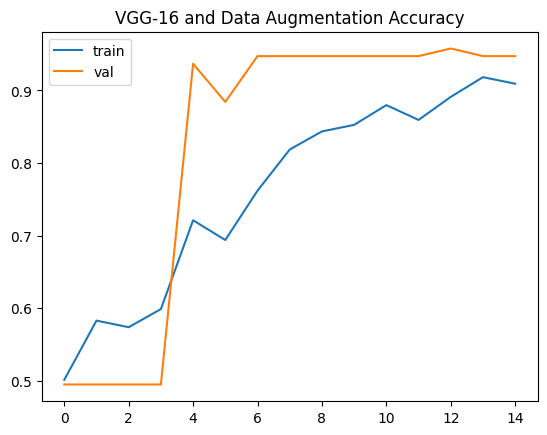


Train performance metrics
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step
   Accuracy    Recall  Precision  F1 Score
0  0.492063  0.492063   0.242126  0.324553

Test performance metrics
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
   Accuracy    Recall  Precision  F1 Score
0  0.494737  0.494737   0.244765  0.327502
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


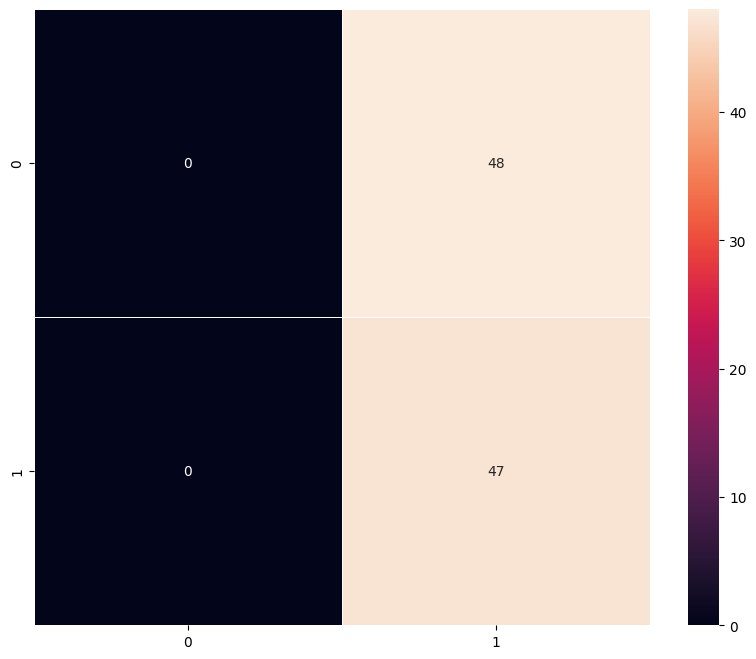

In [44]:
y_pred_probs = vgg_aug.predict(X_test_vgg, verbose=0)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

vggaug_eval = vgg_aug.evaluate(X_test_vgg, y_test, verbose=0)
print("VGG-16 and Data Augmentation Test Accuracy:", vggaug_eval[1])

plt.plot(history_vggaug.history['accuracy'], label='train')
plt.plot(history_vggaug.history['val_accuracy'], label='val')
plt.title('VGG-16 and Data Augmentation Accuracy')
plt.legend()
plt.show()

y_train_pd = pd.Series(y_train)
y_val_pd   = pd.Series(y_val)
y_test_pd  = pd.Series(y_test)

print("\nTrain performance metrics")
vggaug_train_perf = model_performance_classification(vgg_aug, X_train_vgg, y_train_pd)
print(vggaug_train_perf)

print("\nTest performance metrics")
vggaug_test_perf = model_performance_classification(vgg_aug, X_test_vgg, y_test_pd)
print(vggaug_test_perf)

plot_confusion_matrix(vgg_aug, X_test_vgg, y_test_pd, ml=True)


# **Model Performance Comparison and Final Model Selection**

In [45]:
models = {
    "CNN": cnn,
    "VGG16": vgg,
    "VGG16+FFNN": vgg_ff,
    "VGG16+FFNN+Aug": vgg_aug
}
results = {}
for name, model in models.items():
    acc = model.evaluate(X_test_vgg_pp if "VGG" in name else X_test, y_test, verbose=0)[1]
    results[name] = acc
pd.DataFrame(results, index=["Test Accuracy"]).T.sort_values(by="Test Accuracy", ascending=False)


,Test Accuracy
VGG16,1.000000
VGG16+FFNN,1.000000
CNN,0.978947
VGG16+FFNN+Aug,0.357895


## Test Performance

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

CNN Performance:
Accuracy:  0.9789
Precision: 1.0000
Recall:    0.9574
F1-score:  0.9783


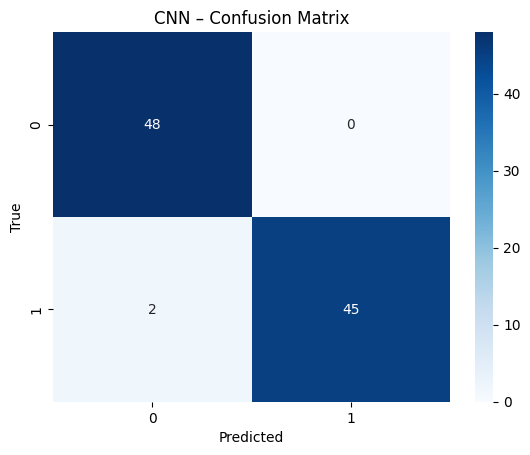

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step

VGG16 Performance:
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-score:  1.0000


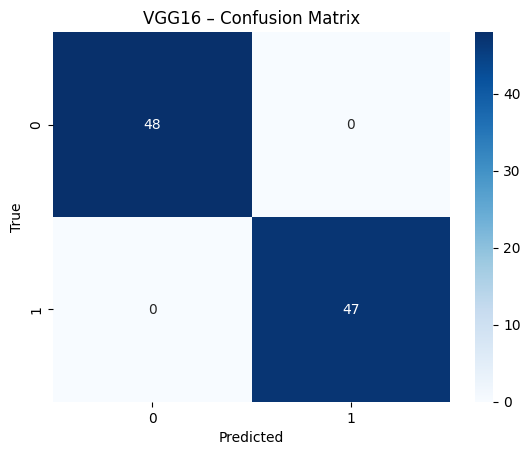

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step

VGG16+FFNN Performance:
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-score:  1.0000


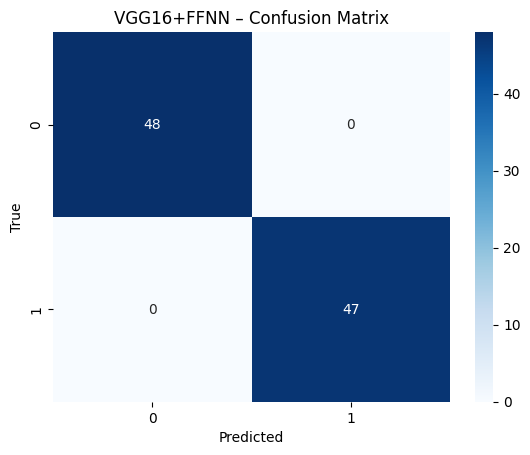

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step

VGG16+FFNN+Aug Performance:
Accuracy:  0.3579
Precision: 0.4103
Recall:    0.6809
F1-score:  0.5120


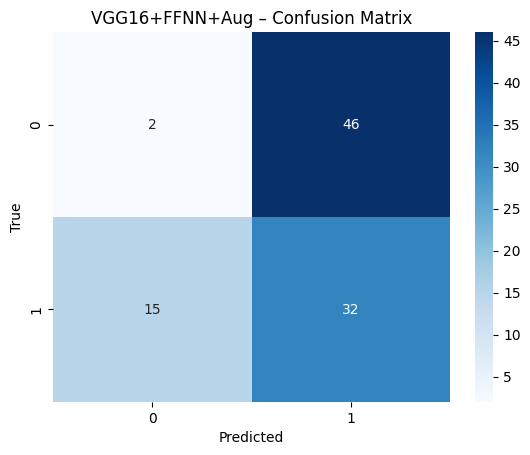

In [46]:
def evaluate_model(model, X, y, model_name):
    y_pred_probs = model.predict(X)
    y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred)
    rec = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    print(f"\n{model_name} Performance:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} – Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()

    return {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}

# Evaluate all models
results = {}
for name, model in models.items():
    X_input = X_test_vgg_pp if "VGG" in name else X_test
    results[name] = evaluate_model(model, X_input, y_test, name)

# **Actionable Insights & Recommendations**

**Model Performance Summary**


- Some models (VGG16 and VGG16 + FFNN) showed 100% accuracy, which likely indicates overfitting or data overlap, meaning the results may not hold up in real-world use.


- The simpler CNN model delivered strong and more realistic performance (~98%), suggesting it could be a more reliable choice for operational testing.


- The augmented data version performed poorly (~36%), showing that the current approach to data enhancement should be revised.




**Key Takeaways**

- The dataset is too limited or repetitive, preventing the model from learning patterns that generalize to new data.


- Data preparation and validation processes need review to ensure reliable testing.


- Simpler, faster models may already provide sufficient accuracy for business needs while being easier to maintain.




**Recommendations**


- Review and strengthen data governance, ensuring clear separation between training and testing datasets.


- Invest in collecting more real-world data to build a stronger and more diverse training base.


- Adopt the simpler CNN model for short-term use or pilot testing, as it balances performance and efficiency.


- Plan a validation phase using real operational data before any deployment decisions.


- Treat current results as preliminary, not final — further testing and data expansion are essential to confirm performance.todo

<font size=5 color='blue'>Power Ahead!</font>
___

In [47]:
%%shell
jupyter nbconvert --to html --template=classic \
"/content/drive/MyDrive/Colab Notebooks/HelmNet_Full_Code_0711.ipynb" \
--output "/content/drive/MyDrive/Colab Notebooks/HelmNet_Full_Code_0711.html"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/HelmNet_Full_Code_0711.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 9 image(s).
[NbConvertApp] Writing 1529381 bytes to /content/drive/MyDrive/Colab Notebooks/HelmNet_Full_Code_0711.html
